In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


In [2]:
print(torch.__version__)

0.4.0


In [3]:
from torchvision.transforms import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=28),
    transforms.CenterCrop((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.Resize(size=28),
    transforms.CenterCrop((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_trainset = datasets.MNIST(root='./data',train=True,download=True,transform=train_transform)
mnist_testset = datasets.MNIST(root='./data',train=False,transform=test_transform)


In [4]:
mnist_trainset.train_data.shape

torch.Size([60000, 28, 28])

In [5]:
batch_size = 128

train_loader = DataLoader(dataset=mnist_trainset , batch_size=batch_size , shuffle=True , num_workers=0)
test_loader = DataLoader(dataset=mnist_testset , batch_size=batch_size , shuffle=True , num_workers=0)


In [6]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [7]:

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # 28 * 28
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3,stride=1,padding=1)
        
        # 14 * 14 * 10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3,stride=1,padding=1)
        
        # 7 * 7 * 20
        self.conv2_drop = nn.Dropout2d()
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7*7*20, 50)
        self.fc2 = nn.Linear(50, 10)

        
    def forward(self,x):
        
        x = F.relu(self.maxpool(self.conv1(x)))
#         print(x.shape)
        x = F.relu(self.maxpool(self.conv2_drop(self.conv2(x))))
#         print(x.shape)
        x = x.view(-1, 7*7*20)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
    
model = Net()
print(model)

# move tensors to GPU if CUDA is available
train_on_gpu = False
if torch.cuda.is_available():
    train_on_gpu = True
    print('train_on_gpu')
else:
    print('train_on_cpu')

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
train_on_gpu


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)



In [9]:
n_epochs = 20
# print_every=20

model.train()

for epoch in range(n_epochs):
    
    losses=0
    
    for idx, (batch_x,target) in enumerate(train_loader):
        
        
        if train_on_gpu:
            batch_x , target = batch_x.cuda(),target.cuda()
        optimizer.zero_grad()
        out = model(batch_x)
        
        loss = criterion(out,target)
        loss.backward()
        
        optimizer.step()

        losses = losses + loss.item()*batch_x.size(0)
        

        
    loss_avg = losses / len(train_loader.dataset)
    print("({}/{}) train loss : {:.4f}".format(epoch+1,n_epochs,loss_avg))



(1/20) train loss : 1.5035
(2/20) train loss : 0.6567
(3/20) train loss : 0.5285
(4/20) train loss : 0.4618
(5/20) train loss : 0.4174
(6/20) train loss : 0.3812
(7/20) train loss : 0.3467
(8/20) train loss : 0.3237
(9/20) train loss : 0.3071
(10/20) train loss : 0.2914
(11/20) train loss : 0.2798
(12/20) train loss : 0.2668
(13/20) train loss : 0.2579
(14/20) train loss : 0.2459
(15/20) train loss : 0.2397
(16/20) train loss : 0.2341
(17/20) train loss : 0.2264
(18/20) train loss : 0.2221
(19/20) train loss : 0.2167
(20/20) train loss : 0.2104


In [10]:
import os

In [11]:
os.makedirs('./model' , exist_ok = True)
torch.save(model.state_dict() , './model/mytraining.pt')



In [12]:
model.load_state_dict(torch.load('./model/mytraining.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [21]:
test_iter = iter(test_loader)
test_data,test_label = next(test_iter)

In [33]:
test_ = test_data[0]
test_ = test_.unsqueeze(0)


In [62]:


if train_on_gpu:
    test_,test_label = test_.cuda(),test_label.cuda()

res = model(test_)
pred = res.argmax()


In [69]:
import matplotlib.pyplot as plt

In [75]:
test_.squeeze().shape

torch.Size([28, 28])

predict resule: 8


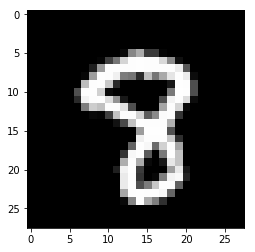

In [79]:
print(f"predict resule: {pred.item()}")
plt.imshow(test_.squeeze(),cmap='gray')
